# IS-02 Machine Learning - Data and Web Science
## Lecture 5: Instance-based Learning
## Project 4 - KNN
### <i>Avgitidis Konstantinos AM: 65</i>

In [1]:
#Importing necessary libraries
import pandas as pd 
import sklearn
import pickle
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics, model_selection
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
data = pd.read_csv('titanic.csv') #Load data into an DataFrame 
print(data.dtypes,end='\n\n')
print(f"Rows: {data.shape[0]}\nColumns: {data.shape[1]}")

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Rows: 891
Columns: 12


In [3]:
#Let's see if we have any NaN values
data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [4]:
#Dropping these values
data.dropna(axis=0,how='any',inplace=True)
print(f"Shape of DataFrame after dropping NaN rows:\nRows: {data.shape[0]}\nColumns: {data.shape[1]}")

Shape of DataFrame after dropping NaN rows:
Rows: 183
Columns: 12


In [5]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [6]:
#Split the dataset into target and data, our target is Survived
target = data['Survived']
data.drop(columns='Survived',inplace=True)

In [7]:
#Let's see if these columns contain any useful information
print(data['Ticket'].value_counts(),end='\n')
print(data['Cabin'].value_counts(),end='\n')
print(data['PassengerId'].value_counts(),end='\n')

19950       4
113760      4
113781      3
PC 17582    3
110413      3
           ..
113514      1
PC 17610    1
PC 17592    1
13213       1
19877       1
Name: Ticket, Length: 127, dtype: int64
C23 C25 C27    4
B96 B98        4
G6             4
F33            3
C22 C26        3
              ..
E63            1
C99            1
E33            1
D46            1
C148           1
Name: Cabin, Length: 133, dtype: int64
717    1
341    1
338    1
337    1
592    1
      ..
537    1
672    1
551    1
413    1
633    1
Name: PassengerId, Length: 183, dtype: int64


In [8]:
#Dropping columns that have too many different values in order to not overfit our model
#Also Name is very generic and not usefull in our case
data.drop(columns=['PassengerId','Cabin','Ticket','Name'],inplace=True)

In [9]:
#Some information about our data
data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000
mean,1.191257,35.674426,0.464481,0.475410,78.682469
std,0.515187,15.643866,0.644159,0.754617,76.347843
min,1.000000,0.920000,0.000000,0.000000,0.000000
25%,1.000000,24.000000,0.000000,0.000000,29.700000
50%,1.000000,36.000000,0.000000,0.000000,57.000000
75%,1.000000,47.500000,1.000000,1.000000,90.000000
max,3.000000,80.000000,3.000000,4.000000,512.329200


In [10]:
#One-Hot Encoding for Object types
data = pd.get_dummies(data,columns=['Sex','Embarked'])

In [11]:
data.head() #What we're left with

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,1
6,1,54.0,0,0,51.8625,0,1,0,0,1
10,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,58.0,0,0,26.5500,1,0,0,0,1


In [12]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target.astype('float'),random_state=42,test_size=0.15) #Splitting the data

In [13]:
scaler = MinMaxScaler() #Instansiating the Scaler

In [14]:
x_train= scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
#Creating our DataFrame of Rule-Based models
#We really dont want to be creating the models each time so lets pickle it or laod it if we've previously created it
#The first loop's index can changed to a smaller int to decrease computation time
#Multithreading can also help cut down time
models = pd.DataFrame()
amodel = []
try:
    models = pickle.load( open( "knn.p", "rb" ) )
except Exception:
    #Initialise the DataFrame we're going to be using
    columns = ['Number of neighbors',	'Weighted/Uniform',	'Metric',	'p',	'Accuracy',	'Recall',	'Precision',	'F1 Score',	'Number of Neighbors']
    models = pd.DataFrame(columns=columns) 
    for k in range(1,x_train.shape[0]): #We can't have more than 155 neighbors (85% of 183)
        for j in range(1,4):
            learner = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=j, metric='minkowski').fit(x_train,y_train)
            learner_ = KNeighborsClassifier(n_neighbors=k, weights='distance', p=j, metric='minkowski').fit(x_train,y_train)
            amodel.append('1-200')
            amodel.append('uniform')
            amodel.append('Minkowski')
            amodel.append(j)
            pred = learner.predict(x_test)
            pred_ = learner_.predict(x_test)
            amodel.append(metrics.accuracy_score(y_test,pred))
            amodel.append(metrics.recall_score(y_test, pred))
            amodel.append(metrics.precision_score(y_test, pred))
            amodel.append(metrics.f1_score(y_test, pred))
            amodel.append(k)
            models = models.append(pd.DataFrame([amodel], columns=columns))
            amodel.clear()
            amodel.append('1-200')
            amodel.append('distance')
            amodel.append('Minkowski')
            amodel.append(j)
            amodel.append(metrics.accuracy_score(y_test,pred_))
            amodel.append(metrics.recall_score(y_test, pred_))
            amodel.append(metrics.precision_score(y_test, pred_))
            amodel.append(metrics.f1_score(y_test, pred_))
            amodel.append(k)
            models = models.append(pd.DataFrame([amodel], columns=columns))
            amodel.clear()
    models.reset_index(drop=True)
    pickle.dump(models, open( "knn.p", "wb" ) )


In [16]:
#Ok now let's impute the missing values
data = pd.read_csv('titanic.csv')
data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [17]:
#Again let's see if these columns contain any useful information
print(data['Ticket'].value_counts(),end='\n')
print(data['Cabin'].value_counts(),end='\n')
print(data['PassengerId'].value_counts(),end='\n')

1601        7
347082      7
CA. 2343    7
347088      6
CA 2144     6
           ..
349217      1
28664       1
C 4001      1
19952       1
364512      1
Name: Ticket, Length: 681, dtype: int64
B96 B98        4
C23 C25 C27    4
G6             4
F33            3
C22 C26        3
              ..
A6             1
C99            1
E63            1
C95            1
A7             1
Name: Cabin, Length: 147, dtype: int64
891    1
293    1
304    1
303    1
302    1
      ..
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64


In [18]:
#Ok now Cabin can be useful since it has 147 different values out of 891 rows.abs
#Let's see how many NaN values are inside
np.count_nonzero(np.asarray(data['Cabin'].isna()) == True)

687

In [19]:
# Ok nevermind Cabin, let's impute those missing values of the Age column
# df = pd.DataFrame()
# df['Age'] = data['Age']
# df.dropna(inplace=True)
# data['Age'].fillna(df['Age'].values.mean(), inplace=True)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data['Age'] = imp.fit_transform(data[['Age']])


In [20]:
np.count_nonzero(np.asarray(data['Age'].isna()) == True) #Should be 0

0

In [21]:
data.isna().any() #Seems we imputed the missing values of the Age column

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [22]:
#Same stuff
target = data['Survived']
data.drop(columns='Survived',inplace=True)
data.drop(columns=['PassengerId','Cabin','Ticket','Name'],inplace=True)
data = pd.get_dummies(data,columns=['Sex','Embarked'])
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, target.astype('float'),random_state=42,test_size=0.15)
scaler_ = MinMaxScaler()
x_train = scaler_.fit_transform(x_train)
x_test = scaler_.transform(x_test)

In [23]:
#Creating our DataFrame of Rule-Based models
#We really dont want to be creating the models each time so lets pickle it or laod it if we've previously created it
#The first loop's index can changed to a smaller int to decrease computation time
#Multithreading can also help cut down time
models_ = pd.DataFrame()
try:
    models_ = pickle.load( open( "knn_fillna.p", "rb" ) )
except Exception:
    #Initialise the DataFrame we're going to be using
    columns = ['Number of neighbors',	'Weighted/Uniform',	'Metric',	'p',	'Accuracy',	'Recall',	'Precision',	'F1 Score',	'Number of Neighbors']
    models_ = pd.DataFrame(columns=columns) 
    for k in range(1,201):
        for j in range(1,4):
            learner = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=j, metric='minkowski').fit(x_train,y_train)
            learner_ = KNeighborsClassifier(n_neighbors=k, weights='distance', p=j, metric='minkowski').fit(x_train,y_train)
            amodel.append('1-200')
            amodel.append('uniform')
            amodel.append('Minkowski')
            amodel.append(j)
            pred = learner.predict(x_test)
            pred_ = learner_.predict(x_test)
            amodel.append(metrics.accuracy_score(y_test,pred))
            amodel.append(metrics.recall_score(y_test, pred))
            amodel.append(metrics.precision_score(y_test, pred))
            amodel.append(metrics.f1_score(y_test, pred))
            amodel.append(k)
            models_ = models_.append(pd.DataFrame([amodel], columns=columns))
            amodel.clear()
            amodel.append('1-200')
            amodel.append('distance')
            amodel.append('Minkowski')
            amodel.append(j)
            amodel.append(metrics.accuracy_score(y_test,pred_))
            amodel.append(metrics.recall_score(y_test, pred_))
            amodel.append(metrics.precision_score(y_test, pred_))
            amodel.append(metrics.f1_score(y_test, pred_))
            amodel.append(k)
            models_ = models_.append(pd.DataFrame([amodel], columns=columns))
            amodel.clear()
    models_.reset_index(drop=True)
    pickle.dump(models_, open( "knn_fillna.p", "wb" ) )

In [24]:
#Selecting only one experiment
models_exp = pd.DataFrame(models)
models_exp_ = pd.DataFrame(models_)
models_exp.sort_values(by=['Weighted/Uniform','p'],axis=0,ascending=False)
models_exp.drop_duplicates(subset=['Number of Neighbors'],keep='first',inplace=True)
models_exp_.sort_values(by=['Weighted/Uniform','p'],axis=0,ascending=False)
models_exp_.drop_duplicates(subset=['Number of Neighbors'],keep='first',inplace=True)

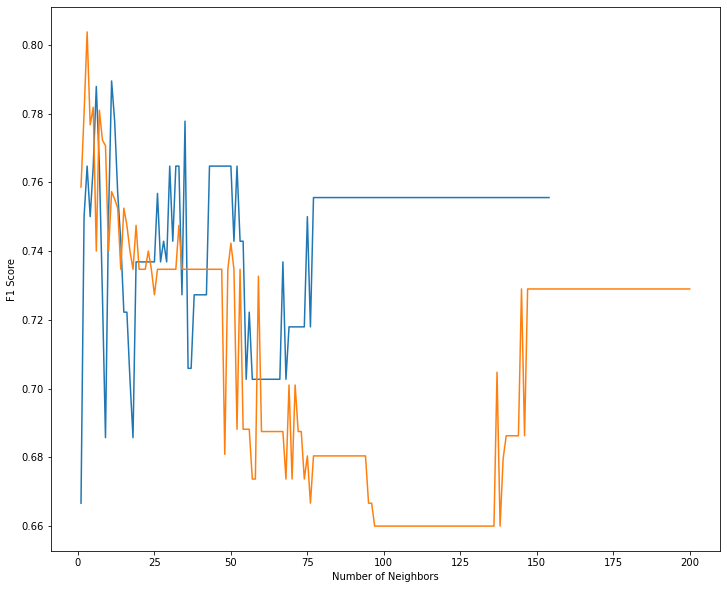

In [25]:
#Lets plot the results of the 2 models
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(12,10))
sns.lineplot(x='Number of Neighbors',y='F1 Score',data=models_exp,ax=axs)
sns.lineplot(x='Number of Neighbors',y='F1 Score',data=models_exp_,ax=axs)

In [26]:
from pandas import ExcelWriter
with ExcelWriter(path="KNN_Results_all.xlsx",engine='openpyxl',mode='w') as xl_writer:
    models_.to_excel(excel_writer=xl_writer,sheet_name='Sheet1',index=False,float_format="%.6f",freeze_panes=(1,0)) #Saving every model to an excel

In [27]:
#Getting the highest F1 Score
models_.sort_values(by='F1 Score',axis=0,ascending=False,inplace=True)
models_.drop_duplicates(subset=['Weighted/Uniform','p'],keep='first',inplace=True)
models_.reset_index(drop=True)
models_.rename(columns={'Number of Neighbors':'Neighbors count of best F1','F1 Score':'Best F1'},inplace=True)
models_.sort_values(by='Weighted/Uniform',axis=0,ascending=False,inplace=True)
models_.sort_values(by='p',axis=0,ascending=True,inplace=True)

In [28]:
with ExcelWriter(path="KNN_Results.xlsx",engine='openpyxl',mode='w') as xl_writer:
    models_.to_excel(excel_writer=xl_writer,sheet_name='Sheet1',index=False,float_format="%.6f",freeze_panes=(1,0)) #Saving best models to excel

In [29]:
fig.savefig('KNN-F1.png')